In [3]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 07: Base Model Tree Traversal
Inspect the model trees for more information about differences in ALE vs. Shapley for the int_rate:term interaction
 * Gather overall stats about how often term and int_rate occur in trees 
 * Get some descriptive plots relating to term and interest rate

*This script takes about 1 minutes on my MacBook Air*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import scipy.sparse as sp

In [5]:
setup.plot_defaults()

## Import Data

##### Predictors

In [6]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - use sample of training data

In [7]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

##### Model

In [8]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

## Overall Tree Stats
Count nodes for interest rates and term, and see whether any low term values lead to higher predictions

In [9]:
# Get the indices of our features of interest - int_rate and term

In [10]:
term_index = predictor_features.index('term')

In [11]:
int_rate_index = predictor_features.index('int_rate')

In [12]:
# get the estimators

In [13]:
base_model_est = base_model.estimators_

In [16]:
len(base_model_est)

20

##### Function to get tree stats

In [17]:
def get_tree_stats(tree, node_id = 0, 
                   info_ary = np.array([0, 0, 0, 0, 0]),
                   int_rate_index = int_rate_index,
                   term_index = term_index):
    """ Traverses the tree, counting nodes of various types.
    Recursive function.  Usualy you willl not modify node_id or
    info_ary; these are used during recursion.
      Inputs:
        tree:  The tree to traverse (estimator)
        node_id: Starting node for counting.  0 indicates the root,
        info_ary:  Start counts of various nodes.  See "Value".
          Leave as arrays of 0 to count items at or below node_id
        int_rate_index: Integer index of the interest rate variable; needed
            as the trees do not include feature names.
        term_index: Integer index of the term variable
      Value:  Numpy array containing tree information.  The 5 items are:
        total nodes
        total nodes for the interest rate feature
        total nodes for the term feature
        total nodes for the term feature, where the left value is larger
        total nodes for the term feature, where the right value is larger
    """ 
    
    info_ary = info_ary.copy()
    
    # Count nodes
    info_ary[0] += 1
    
    # Get children
    this_left = tree.tree_.children_left[node_id]
    this_right = tree.tree_.children_right[node_id]
    
    # If a leaf node, return
    if this_left == this_right:
        return info_ary
    
    this_feature = tree.tree_.feature[node_id]
    
    if (this_feature == int_rate_index):
        info_ary[1] += 1
    elif (this_feature == term_index):
        info_ary[2] += 1
        value_left = tree.tree_.value[this_left][0][0]
        value_right = tree.tree_.value[this_right][0][0]
        if value_left >= value_right:
            info_ary[3] += 1
        else:
            info_ary[4] += 1
        
    # Helper function to pass most features to the next node
    def return_node(node_id):
        return get_tree_stats(tree, node_id, 
                   info_ary = info_ary,
                   int_rate_index = int_rate_index,
                   term_index = term_index)
    
    # Traverse tree both ways
    return return_node(this_left) + \
            return_node(this_right)
                

##### Get stats for all trees

In [18]:
tree_stats = pd.concat([pd.DataFrame(get_tree_stats(e)).T \
                        .set_axis(['tot_node', 'int_rate_node', 
                                   'term_node',  'term_node_left', 'term_node_right'], 
                                  axis=1) \
                        for e in base_model_est[:,0]], 
                       axis=0, keys = range(0, len(base_model_est))) \
    .reset_index(level=0, drop=False) \
    .rename(columns={'level_0': 'tree_index'}) \
    .reset_index(drop=True)
                       

In [19]:
tree_stats.head(3)

,tree_index,tot_node,int_rate_node,term_node,term_node_left,term_node_right
0,0,192,86,24,0,24
1,1,192,78,24,0,24
2,2,192,82,16,0,16


In [20]:
tree_stats.to_csv(Path(setup.temp_path).joinpath('07_REPORT_tree_stats_all.csv'),
                  index=False)

In [21]:
tree_stats_summary = tree_stats.describe()
tree_stats_summary

,tree_index,tot_node,int_rate_node,term_node,term_node_left,term_node_right
count,20.00000,20.000000,20.000000,20.000000,20.0,20.000000
mean,9.50000,185.550000,42.850000,10.050000,0.0,10.050000
std,5.91608,13.315899,27.722829,8.864328,0.0,8.864328
min,0.00000,145.000000,2.000000,0.000000,0.0,0.000000
25%,4.75000,185.000000,17.000000,2.000000,0.0,2.000000
50%,9.50000,192.000000,41.000000,8.000000,0.0,8.000000
75%,14.25000,192.000000,63.500000,17.250000,0.0,17.250000
max,19.00000,192.000000,86.000000,24.000000,0.0,24.000000


In [22]:
tree_stats_summary.to_csv(Path(setup.temp_path).joinpath('07_REPORT_tree_stats_summary.csv'),
                  index=True)

### Trees: Decision Paths
Get decision paths for sample cases.  See how often these experience the 'term' and "int rate" features.  Also get information about size of splits at term, number of nodes traversed, etc.

In [50]:
# Function to get the value difference for the nodes involving a
# feature.  Get the mean per path.

In [51]:
def path_value_diff(tree, decision_paths,
                     feature_index = term_index):
    """ For decision paths in a tree, find the first node involving
    a specified feature, if any.  Then, find the change in value
    for the left and right paths after that split"""
    
    # Flag nodes involving the feature in the tree:
    feature_nodes = (tree.tree_.feature == feature_index)
    
    # Repeat the matrix to match the number of decision paths
    feature_nodes_mat = np.asmatrix(np.repeat(feature_nodes, 
                                              decision_paths.shape[0], 0) \
        .reshape((feature_nodes.shape[0], decision_paths.shape[0])).T)
    
    # Element-wise multiplication to get nodes in the decision paths
    # involving the feature
    decision_paths_mask = decision_paths.multiply(feature_nodes_mat)
    found_ind = sp.find(decision_paths_mask == 1)
    
    # Convert to a data frame
    found_df = pd.DataFrame({'ind':found_ind[0], 'node':found_ind[1]}) \
        .sort_values('ind')
    
    # Get the splits
    found_df['val_left'] = found_df['node'] \
        .apply(lambda x: tree.tree_.value[tree.tree_.children_left[x]][0][0])
    found_df['val_right'] = found_df['node'] \
        .apply(lambda x: tree.tree_.value[tree.tree_.children_right[x]][0][0])
    found_df['val_diff'] = found_df['val_right']  - found_df['val_left']
    
    # Get the number of samples reaching this node
    found_df['node_samp'] = found_df['node'] \
        .apply(lambda x: tree.tree_.n_node_samples[x])
    
    # Get mean per path
    found_agg = found_df.groupby('ind')[['val_diff', 'node_samp']].apply('max')
    
    return found_agg

    

In [52]:
# Function to get decision path information for a tree

In [53]:
def decision_path_counter(tree, X,
                          int_rate_index = int_rate_index,
                         term_index = term_index):
    """ Looks at decision paths in a tree for a dataset, and
    counts the number of times the interest rate and term features
    occur for each observation.  Also returns some overall tree stats
    """
    
    # Get features of interest
    int_rate_features = (tree.tree_.feature == int_rate_index)
    term_features = (tree.tree_.feature == term_index)
    
    # Get the decision paths for the observations in X
    decision_paths = tree.decision_path(X)
    
    # Count nodes of each type
    node_count_int_rate = decision_paths * int_rate_features
    node_count_term = decision_paths * term_features
    
    # Convert to a series
    count_df = pd.concat([pd.Series(node_count_int_rate).rename('int_rate_traversed'),
                          pd.Series(node_count_term).rename('term_traversed')],
                         axis=1)
    
    # Append overall tree information
    count_df['int_rate_total'] = np.sum(int_rate_features)
    count_df['term_total'] = np.sum(term_features)
    count_df['total_nodes'] = tree.tree_.node_count
    
    # Get the total decision path length
    count_df['dec_path_len'] = pd.Series(np.squeeze(np.asarray(np.sum(decision_paths, 
                                                                      axis=1))))
    
    # Find split info for term
    term_split_val = path_value_diff(tree, decision_paths, term_index)
    
    count_df = count_df.merge(term_split_val, left_index = True, right_index=True,
                             how='left')

    return count_df

In [54]:
# Get stats for all trees

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    node_counts = pd.concat([decision_path_counter(e, train_samp_df[predictor_features]) \
                             for e in base_model_est[:,0]], axis=0,
                            keys = range(0, len(base_model_est))) \
        .reset_index(level=1, drop=False) \
        .rename(columns={'level_1': 'case_index'}) 

In [55]:
node_counts['val_diff'] = node_counts['val_diff'].fillna(0)
node_counts['node_samp'] = node_counts['node_samp'].fillna(0)

In [82]:
node_counts.to_csv(Path(setup.temp_path).joinpath('07_REPORT_decision_path_info.csv'),
                  index=False)

In [56]:
node_counts.head()

,case_index,int_rate_traversed,term_traversed,int_rate_total,term_total,total_nodes,dec_path_len,val_diff,node_samp
0,0,2,1,10,3,63,6,0.063854,68264.0
0,1,2,1,10,3,63,6,0.063854,68264.0
0,2,3,1,10,3,63,6,0.111085,39073.0
0,3,3,0,10,3,63,6,0.000000,0.0
0,4,3,1,10,3,63,6,0.111085,39073.0


In [58]:
node_counts.shape

(2000000, 8)

In [ ]:
node_counts_tot = node_counts.groupby('case_index')\
    .agg('mean')

In [58]:
node_counts_tot.shape

(100000, 8)

In [59]:
dec_path_info_merge = pd.concat([train_samp_df[['int_rate', 'term']], node_counts_tot], axis=1)

In [60]:
dec_path_info_merge['int_rate_q'] = pd.cut(dec_path_info_merge['int_rate'], 25)
dec_path_info_merge['int_rate_q'] = dec_path_info_merge['int_rate_q'].apply(lambda x: x.mid) \
    .astype('float')

In [61]:
dec_path_agg = dec_path_info_merge.groupby(['int_rate_q', 'term']) \
    .agg('mean') \
    .reset_index()

In [112]:
# Function to plot one of the features in the decision path summary
def plot_fig_single(data, y, ax, color_dict):
    for name, group in data.groupby('term'):
        group.plot(x='int_rate', y=y,kind='scatter',
              color=color_dict[name], ax=ax, label=name)

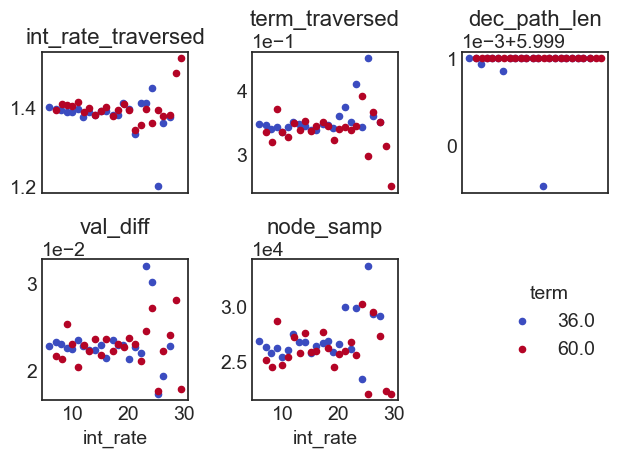

In [137]:
cmap = mpl.cm.coolwarm
color_categories = [36,60]
cnorm  = mpl.colors.Normalize(vmin=0, vmax= 1)
color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
                  for i in range(0, 2)}


fig, ax = plt.subplots(2,3, sharex=True)
plot_feat = ['int_rate_traversed', 'term_traversed', 
              'dec_path_len', 'val_diff', 'node_samp']
for i, feat in enumerate(plot_feat):
    ax_row = int(i/3.0)
    ax_col = i % 3
    #print(f'{ax_row} {ax_col}')
    #plot_fig_single(
    plot_fig_single(dec_path_agg, feat, ax=ax[ax_row, ax_col], color_dict = color_dict)
    ax[ax_row, ax_col].set_ylabel(None)
    ax[ax_row, ax_col].title.set_text(feat)
    ax[ax_row, ax_col].ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    if i < (len(plot_feat) - 1):
        ax[ax_row, ax_col].get_legend().remove()
    else:
        handles, labels = ax[ax_row, ax_col].get_legend_handles_labels()
        fig.legend(handles, labels, loc = (0.8, 0.2), title='term')
        ax[ax_row, ax_col].get_legend().remove()
for i in range(len(plot_feat), 6):
    ax_row = int(i/3.0)
    ax_col = i % 3
    fig.delaxes(ax[ax_row][ax_col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('07_PLOT_decision_path_means.png'))

### Trees: Interest Rate Thresholds
Get interest rate thresholds for each node involving interest rate

In [ ]:
# Function to return thresholds in a tree

In [182]:
def get_thresholds_feature(tree, feature_index=int_rate_index):
    """ Returns all thresholds for a given feature"""
    
    # Get indices of feature of interest
    features_ind = (tree.tree_.feature == feature_index)
    
    # Get the thresholds
    thresh = tree.tree_.threshold[features_ind]
    
    # Get the samples at the nodes
    node_samp = tree.tree_.n_node_samples[features_ind]
    
    return pd.DataFrame({'thresh': thresh,
                        'node_samp': node_samp})

In [156]:
# Get all thresholds

In [161]:
int_rate_index

2

In [175]:
get_thresholds_feature(base_model_est[6,0], int_rate_index)

,thresh
0,12.565
1,18.965


In [183]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    thresh_vals = pd.concat([get_thresholds_feature(e) \
                             for e in base_model_est[:,0]], axis=0,
                            keys = range(0, len(base_model_est))) \
        .reset_index(level=1, drop=False) \
        .rename(columns={'level_1': 'case_index'}) 

In [184]:
thresh_vals.describe()

,case_index,thresh,node_samp
count,87.000000,87.000000,87.000000
mean,2.218391,16.785460,75174.988506
std,2.042714,6.661394,82006.255238
min,0.000000,5.995000,59.000000
25%,1.000000,10.775000,6866.500000
50%,2.000000,16.520000,37189.000000
75%,3.000000,22.950000,123913.500000
max,9.000000,30.570000,235429.000000


In [ ]:
thresh_vals[

<AxesSubplot: ylabel='Frequency'>

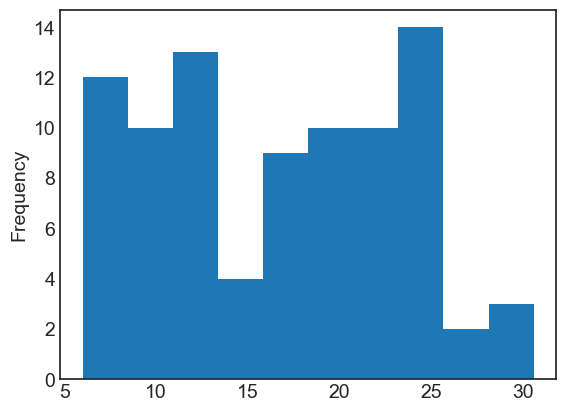

In [185]:
thresh_vals['thresh'].plot(kind='hist')

<AxesSubplot: xlabel='thresh', ylabel='node_samp'>

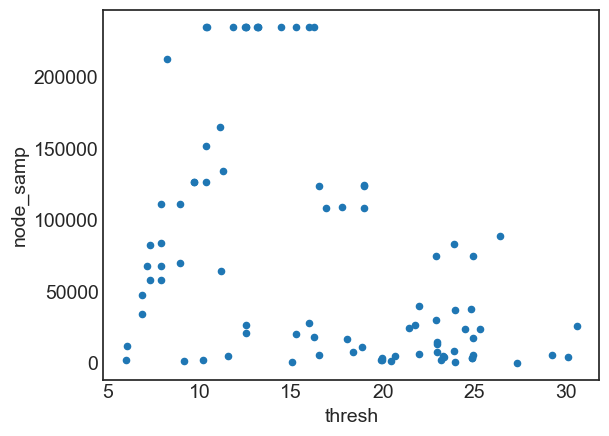

In [186]:
thresh_vals[['thresh', 'node_samp']].plot(kind='scatter', x='thresh',
                                         y='node_samp')

In [170]:
pd.DataFrame({'thresh': tree.tree_.threshold[int_rate_features]})

,thresh
0,12.565
1,18.965


In [146]:
tree.tree_.threshold

array([ 1.31750002e+01,  9.73000002e+00,  7.93499994e+00,  7.42500000e+02,
        6.32500000e+02, -2.00000000e+00, -2.00000000e+00,  4.21740000e+04,
       -2.00000000e+00, -2.00000000e+00,  5.00000000e-01,  5.20250000e+04,
       -2.00000000e+00, -2.00000000e+00,  4.50000000e+00, -2.00000000e+00,
       -2.00000000e+00,  4.80000000e+01,  5.00000000e-01,  4.50000000e+00,
       -2.00000000e+00, -2.00000000e+00,  1.25650001e+01, -2.00000000e+00,
       -2.00000000e+00,  5.00000000e-01,  7.07500000e+02, -2.00000000e+00,
       -2.00000000e+00,  6.82500000e+02, -2.00000000e+00, -2.00000000e+00,
        1.77849998e+01,  4.80000000e+01,  5.00000000e-01,  1.59749999e+01,
       -2.00000000e+00, -2.00000000e+00,  1.52500000e+01, -2.00000000e+00,
       -2.00000000e+00,  5.00000000e-01,  6.82500000e+02, -2.00000000e+00,
       -2.00000000e+00,  6.92500000e+02, -2.00000000e+00, -2.00000000e+00,
        4.80000000e+01,  2.49399996e+01,  4.01250000e+03, -2.00000000e+00,
       -2.00000000e+00,  

In [92]:
plot_feat = ['int_rate_traversed', 'term_traversed', 
              'dec_path_len', 'val_diff', 'node_samp']
for i, feat in enumerate(plot_feat):
    print(i)

0
1
2
3
4


In [66]:
TO DO
1.PDP plots - show steps at high int rate?
Do they look like ALE or like SHAP?
2. Int rate SHAP as func of interaction - all interactions vs int rate, averaged
  term goes down which go up?

NameError: name 'this_tree' is not defined

In [ ]:
simulation - tree with much larger values at high interest rates, with term splits under these.  Term splits get bigger at higher int rate too but not as fast
maybe int rate grows as x^2, term as x, sample counts highest in the middle